In [1]:
import os
import json
import tqdm
import torch
import datetime
import argparse
import pycocotools.mask as cocomask
from detectron2.utils.file_io import PathManager

In [32]:
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [3]:
INFO = {
    "description": "ImageNet-1K: Self-train",
    "url": "",
    "version": "1.0",
    "year": 2022,
    "contributor": "Xudong Wang",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "Apache License",
        "url": "https://github.com/facebookresearch/CutLER/blob/main/LICENSE"
    }
]

CATEGORIES = [
    {
        'id': 1,
        'name': 'fg',
        'supercategory': 'fg',
    },
]

new_dict_filtered = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],
    "annotations": []
}

category_info = {
    "is_crowd": 0,
    "id": 1
}

In [4]:
def segmToRLE(segm, h, w):
    if isinstance(segm, list):
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = cocomask.frPyObjects(segm, h, w)
        rle = cocomask.merge(rles)
    elif isinstance(segm["counts"], list):
        # uncompressed RLE
        rle = cocomask.frPyObjects(segm, h, w)
    else:
        # rle
        rle = segm
    return rle

def rle2mask(rle, height, width):
    if "counts" in rle and isinstance(rle["counts"], list):
        # if compact RLE, ignore this conversion
        # Magic RLE format handling painfully discovered by looking at the
        # COCO API showAnns function.
        rle = cocomask.frPyObjects(rle, height, width)
    mask = cocomask.decode(rle)
    return mask

def cocosegm2mask(segm, h, w):
    rle = segmToRLE(segm, h, w)
    mask = rle2mask(rle, h, w)
    return mask

In [5]:
# if __name__ == "__main__":
# load model arguments
    # parser = argparse.ArgumentParser(description='Generate labelmaps from json files')
    # parser.add_argument('--ann', type=str, 
    #                     default='DETECTRON2_DATASETS/carotid-mini/annotations/imagenet_train_fixsize480_tau0.15_N3.json',
    #                     help='Path to maskcut annotation or model predictions')
    # parser.add_argument('--dataset', type=str,    
    #                       default='DETECTRON2_DATASETS/carotid-mini/images',
    #                     help='Path to the dataset')
    # parser.add_argument('--save_path', type=str,
    #                     default='DETECTRON2_DATASETS/carotid-mini/labelmaps',
    #                     help='Path to save the generated labelmaps')
    # parser.add_argument('--threshold', type=float, default=0.5,
    #                     help='Confidence score thresholds')
    # args = parser.parse_args()

In [6]:
DETECTRON2_DATASETS="/home/guests/oleksandra_tmenova/test/project/thesis-codebase/data"


In [40]:
ann_path = DETECTRON2_DATASETS+'/carotid-mini/annotations/imagenet_train_fixsize480_tau0.15_N3.json'
# ann_path ="/home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/carotid-mini/annotations/imagenet_train_fixsize480_tau0.15_N3.json"

In [45]:
save_path = DETECTRON2_DATASETS + "/carotid-mini/labelmaps2"

In [46]:
save_path

'/home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/carotid-mini/labelmaps2'

In [47]:
dataset_path = DETECTRON2_DATASETS + '/carotid-mini/images'

In [48]:
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [49]:
# load annotations
# ann_dict = json.load(open(ann_path))
with PathManager.open(ann_path, "r") as f:
    ann_dict = json.load(f)
image_list = ann_dict['images']
annotations = ann_dict['annotations']

In [60]:
image_list

[{'id': 1,
  'file_name': 'train/img0001.jpg',
  'width': 256,
  'height': 256,
  'date_captured': '2023-08-29 11:47:27.705046',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 {'id': 2,
  'file_name': 'train/img0025.jpg',
  'width': 256,
  'height': 256,
  'date_captured': '2023-08-29 11:47:27.705046',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 {'id': 3,
  'file_name': 'train/img0034.jpg',
  'width': 256,
  'height': 256,
  'date_captured': '2023-08-29 11:47:27.705046',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 {'id': 4,
  'file_name': 'train/img0042.jpg',
  'width': 256,
  'height': 256,
  'date_captured': '2023-08-29 11:47:27.705046',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 {'id': 5,
  'file_name': 'train/img0066.jpg',
  'width': 256,
  'height': 256,
  'date_captured': '2023-08-29 11:47:27.705046',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 {'id': 6,
  'file_name': 'train/img0145.jpg',
  'width': 256,
  'height': 256,


In [62]:
# create id to filename mapping
id_to_filename = {}
for image_data in image_list:
    full_file_name = image_data['file_name']
    base_name = os.path.splitext(os.path.basename(full_file_name))[0]
    id_to_filename[image_data['id']] = base_name

In [51]:
# group annotations by images in a new dictionary
image_to_anns = {}
for id, ann in enumerate(annotations):
    if ann['image_id'] in image_to_anns:
        image_to_anns[ann['image_id']].append(ann)
    else:
        image_to_anns[ann['image_id']] = [ann]

In [63]:
# image_to_anns

In [53]:
image_to_labelmaps = {}

In [54]:
def masks2labelmap(masks: list, h: int, w: int):
    # print(len(masks))
    labelmap = np.zeros((h, w), dtype=int) #Check if order h, w is correct
    label = 1 #start from 1, to leave 0 be a background index in the labelmap
    # n_0s = 0
    # n_1s = 0
    for mask in masks:
        # n_0s = n_0s + (mask==0).sum()
        # n_1s = n_1s + (mask==1).sum()
        # print(mask.shape, "0s:", (mask==0).sum(),"1s:", (mask==1).sum())
        labelmap[mask==1] = label
        label = label + 1
    print("Labelmap: 0s:", (labelmap==0).sum(),"1s:", (labelmap==1).sum(), "2s:", (labelmap==2).sum())
    return labelmap

In [64]:
for k, anns in tqdm.tqdm(image_to_anns.items()):
    # if k>1:
        # break
    # print(k)
    # get a list of binary masks
    masks = []
    for ann in anns:
        segm = ann['segmentation']
        mask = cocosegm2mask(segm, segm['size'][0], segm['size'][1])
        masks.append(mask)

    # since anns are grouped per image, can get h,w, name from any ann in the list
    h = anns[0]['height']
    w = anns[0]['width']
    # TODO: figure out a better way to get the actual filename of th eimage (stored in image_list)
    # E.g. can build the original im_ann dictionary using image names, not ids
    image_id = anns[0]['image_id'] 
    image_name = id_to_filename[image_id]
    

    # generate labelmaps
    labelmap = masks2labelmap(masks, h, w)
    image_to_labelmaps[k] = labelmap

    # save labelmap
    output_file = save_path + f'/{image_name}.png'
    # Image.fromarray(labelmap).save(output_file)
    labelmap_im = Image.fromarray(labelmap.astype(np.uint8)).convert('L')
    # labelmap_im = Image.fromarray(np.uint8(labelmap*255)).convert('L')
    # print(labelmap_im)
    labelmap_im.save(output_file)
    
    

    

  0%|          | 0/18 [00:00<?, ?it/s]


Labelmap: 0s: 43366 1s: 13939 2s: 8231


FileNotFoundError: [Errno 2] No such file or directory: '/home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/carotid-mini/labelmaps2/img0001.png'

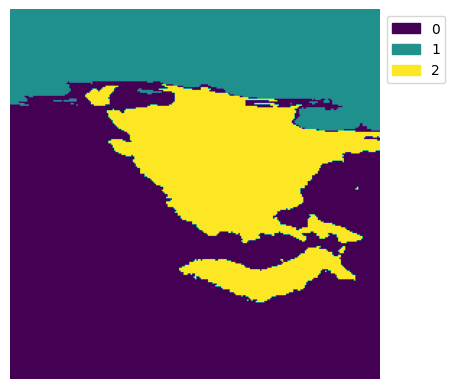

In [59]:
pred = image_to_labelmaps[12]

values = np.unique(pred.ravel())
im = plt.imshow(pred)
plt.axis(False)
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1., 1), loc=2)

In [57]:
# image_to_labelmaps[1]